## Whole Slide Imaging De-identification

In this notebook, we will explore how to handle the de-identification of Whole Slide Imaging (WSI) files, specifically focusing on SVS files.</br>
We will cover:
* Removal of auxiliary images, like macro and label images.
* Removal of Metadata.
* Main image cleaning: in this situation we don't want to remove the entire image like the case of for example macro or label images, but we want to remove only specific regions which contain PHI. We want to do this keeping the quality of the original image intact. This process involves the following steps which we will discuss in next sections,
  * Extract Tiles from SVS
  * Deidentify Tiles
  * Update the original source SVS file to mask tiles containing PHI.

Let's jump right in!

### Introduction to the SVS file format

The SVS file format (commonly used for whole slide images (WSI) in digital pathology) is based on the TIFF format and supports multi-resolution (pyramidal) image storage. It allows storing extremely large images efficiently, along with metadata and multiple resolutions for fast zooming and viewing.
SVS typically stores images in a pyramid of resolutions,
* level 0 -> full resolution.
* level 1 -> downsampled version, like 1/4 of the resolution at level 0.
* ...
* level N -> more downsampling.

Something like this(image taken from nema.org),</br>
![sample wsi](https://dicom.nema.org/dicom/dicomwsi/sup145_fromword_files/image008.gif)

At each level, images are not stored as a single monolithic unit, but as a set of _tiles_. This enables for a more efficient handling of the image by viewers.</br>
We'll see how we can exploit this characteristic to process the images in parallel and in the most efficient manner.

### Real World Example

In [1]:
secret = ""
license = ""
aws_access_key = ""
aws_secret_key = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

### Initialization of spark session

In [34]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = "6.1.1-xyz"

spark = start(use_gpu=True,
              jar_path=spark_ocr_jar_path, nlp_internal="6.1.1", nlp_version="6.1.3", nlp_secret=nlp_secret)

spark

Spark version: 3.5.0
Spark NLP version: 6.1.3
Spark NLP for Healthcare version: 6.1.1
Spark OCR version: 6.1.1



25/10/14 19:05:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Removal of auxiliary images, like macro and label images, along with metadata.
First things first, before diving into the full resolution images, let's see how to remove the auxiliary images and the metadata. For this, the `svs.remove_phi()` comes handy. Let's take a look at the documentation,

In [3]:
from sparkocr.utils.svs.phi_cleaning import remove_phi
help(remove_phi)

Help on function remove_phi in module sparkocr.utils.svs.phi_cleaning:

remove_phi(input, output, tags=['ImageDescription.Filename', 'ImageDescription.Date', 'ImageDescription.Time', 'ImageDescription.User'], append_tags=[], rename=False, verbose=False)
    Remove label images, macro images, and specified metadata from SVS files.

    This function processes SVS files to remove sensitive metadata and associated images.
    By default, it removes specific metadata tags: "ImageDescription.Filename",
    "ImageDescription.Date", "ImageDescription.Time", and "ImageDescription.User".

    Parameters:
    - input (str): The file path or directory containing the SVS files to be de-identified.
    - output (str): The file path or directory where the de-identified files will be saved.
    - tags (list, optional): A list of metadata tags to remove, replacing the default tags if provided.
    - append_tags (list, optional): Additional tags to remove, added to the defaults without overriding them.

So we see from the documentation that we can remove label, and macro images along with a predefined set of metadata tags. We can also add our own custom list of tags.</br>
We have everything we need, so let's do it!,

In [4]:
# make sure input files are in this folder
input_path = './tcia/'
output_path = 'deid_svs'

remove_phi(input_path, output_path, verbose=True)

de-identifying ./tcia/C3L-00608-21.svs
no need to clean: label
no need to clean: macro
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
cleaned tag field: ImageDescription.Filename
cleaned tag field: ImageDescription.Date
cleaned tag field: ImageDescription.Time
cleaned tag field: ImageDescription.User
Copied ./tcia/C3L-00608-21.svs as deid_svs/C3L-00608-21(4).svs


#### [optional] Tweaking additional parameters
You can safely skip this if you are good with the set of metadata tags that were removed.

In [ ]:
input_path = './tcia/C3L-00608-21.svs'
output_path = 'deid_svs'

remove_phi(input_path, output_path, verbose=True, append_tags=['ImageDescription.ScanScope ID', 'ImageDescription.Time Zone', 'ImageDescription.ScannerType'])

#### Cleaning of the main image
Here we will de-identify the main image. We start by pulling the tiles out of the SVS.

In [5]:
!ls -l ./tcia

total 303856
-rw-rw-r-- 1 jose jose 311142779 Oct 14 12:17 C3L-00608-21.svs


In [6]:
input_path = "./tcia/C3L-00608-21.svs"
OUTPUT_FOLDER = "./tiles_output_608-21/"

In [7]:
from sparkocr.utils.svs.tile_extraction import svs_to_tiles

svs_to_tiles(input_path, OUTPUT_FOLDER, level="auto", thumbnail = True)

Processing file: C3L-00608-21.svs


#### Text Detection

In [8]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image

In [9]:
# Repeating the definition here for this path
temp_tile_output = "./tiles_output_608-21/C3L-00608-21/selected"
image_df = spark.read.format("binaryFile").load(temp_tile_output)

At this point, `image_df` has all the tiles, from the selected level in the source SVS file. Next thing we need to do is to try to detect text and PHI in those tiles.</br>
Let's define the pipeline steps we need to accomplish this.

In [26]:
bin_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.9) \
    .setSizeThreshold(-1) \
    .setWidth(0) \
    .setUseGPU(True)

new_stages = [
    bin_to_image,
    text_detector
]

svs_text_detection = PipelineModel(stages=new_stages)

image_text_detector_mem_opt download started this may take some time.


25/10/14 18:21:56 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approximate size to download 77.5 MB


In [27]:
result = svs_text_detection.transform(image_df)

In [28]:
df_tile = result.repartition(4).cache()

2025-10-14 18:21:58.708196162 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-14 18:21:58.708227400 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-14 18:21:58.727986574 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-14 18:21:58.728157984 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2025-10-14 18:21:58.847579255 [W:onnxrun


    Image #0:
    Origin: file:/home/jose/spark-ocr/notebooks/mayo/tiles_output_608-21/C3L-00608-21/selected/C3L-00608-21_L2_T141.jpg
    Resolution: 0 dpi
    Width: 240 px
    Height: 240 px
    Mode: 10
    Number of channels: 1


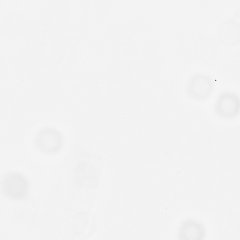

CPU times: user 20.6 ms, sys: 8.8 ms, total: 29.4 ms
Wall time: 9.92 s


In [29]:
%%time
from pyspark.sql.functions import size

result = df_tile.filter(size(result["text_regions"]) > 0).cache()
display_images(result, "image")

**NOTE**: Here we can see the different tiles and the text that was detected on each of them. This image has ~900 tiles at the target level, and we have just one false positive!. Subsequent stages will take care of this. You can filter the tiles with detected text and use it as input for deid pipeline, other tiles won't be fed into the pipeline, so that we don't waste resources analyzing them.

#### Inspect target images
Let's look into some of the images containing text,

#### PHI removal per-se

In [30]:
from sparkocr.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("image_deid_multi_model_context_pipeline_cpu", "en", "clinical/ocr")

image_deid_multi_model_context_pipeline_cpu download started this may take some time.


25/10/14 18:22:34 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Approx size to download 4.9 GB
[ | ]

25/10/14 18:22:35 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/14 18:22:35 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


image_deid_multi_model_context_pipeline_cpu download started this may take some time.
Approximate size to download 4.9 GB
Download done! Loading the resource.
[ / ]

2025-10-14 18:22:39.594600: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-10-14 18:22:39.594620: I external/org_tensorflow/tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[ — ]

2025-10-14 18:22:39.801100: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-14 18:22:39.801703: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-14 18:22:39.806523: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.4/lib64:
2025-10-14 18:22:39.806598: W external/org_tensorflow/tensorflow/stream_executor/platform/

[ \ ]

2025-10-14 18:22:43.749378: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-14 18:22:43.753207: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-10-14 18:22:43.805080: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devi

[ | ]

2025-10-14 18:23:05.014481: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-14 18:23:05.018508: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[ \ ]

2025-10-14 18:23:13.194277: E external/org_tensorflow/tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute validate_shape which is not in the op definition: Op<name=AssignVariableOp; signature=resource:resource, value:dtype -> ; attr=dtype:type; is_stateful=true> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node char_repr_cnn/conv1d/kernel/Assign}}
2025-10-14 18:23:13.274686: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-10-14 18:23:13.279837: W external/org_tensorflow/tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/in

[ / ]

[Stage 183:>                                                        (0 + 1) / 1]

[ — ]

[OK!]


In [31]:
deid_pipeline.model.stages = deid_pipeline.model.stages[1:]

### Run pipeline

In [32]:
result_deid = deid_pipeline.transform(result.withColumnRenamed("image", "image_raw"))
deid_info = result_deid.select("path", "coordinates").distinct()

In [33]:
deid_info.distinct().show(5, False)

25/10/14 18:23:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/10/14 18:23:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
[Stage 201:==========================================>              (3 + 1) / 4]

Using CUDA


2025-10-14 18:23:39.910694553 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 81 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-10-14 18:23:39.933906419 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-14 18:23:39.933919463 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


Using CUDA


2025-10-14 18:23:41.742296302 [W:onnxruntime:, transformer_memcpy.cc:74 ApplyImpl] 45 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
2025-10-14 18:23:41.752321140 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-10-14 18:23:41.752332732 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
25/10/14 18:23:42 WARN PositionFinder: Empty or null entity value is not allowed.
25/10/14 18:23:42 ERROR ImageDrawRegions: Invalid or empty `coordinates`: Ensure it is non-empty and contains 

+-----------------------------------------------------------------------------------------------------------+-----------+
|path                                                                                                       |coordinates|
+-----------------------------------------------------------------------------------------------------------+-----------+
|file:/home/jose/spark-ocr/notebooks/mayo/tiles_output_608-21/C3L-00608-21/selected/C3L-00608-21_L2_T141.jpg|[]         |
+-----------------------------------------------------------------------------------------------------------+-----------+



25/10/14 18:23:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
                                                                                

There were no entities. We stop here!